In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# download NLTK resource
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


In [3]:
def preprocess_text(text):
    """text preprocessing"""
    if pd.isna(text) or text == '':
        return ''

    # lower casing
    text = text.lower()

    # remove URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # remove HTML marks
    text = re.sub(r'<.*?>', '', text)

    # remove mails
    text = re.sub(r'\S+@\S+', '', text)

    # reserve character, number and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?]', '', text)

    # remove duplicate whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # tokenization
    tokens = word_tokenize(text)

    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
print("Loading datasets...")
# loading data
fake_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fake.csv')
true_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/True.csv')

# add label：0=Fake, 1=True
fake_df['label'] = 0
true_df['label'] = 1

# merge dataset
df = pd.concat([fake_df, true_df], ignore_index=True)
print(f"Total samples: {len(df)}")
print(f"Fake news: {len(fake_df)}, True news: {len(true_df)}")

# merge title and content 
df['text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

print("\nPreprocessing text...")
# apply text preprocessing
tqdm.pandas(desc="Preprocessing")
df['processed_text'] = df['text'].progress_apply(preprocess_text)

# filter blank text
df = df[df['processed_text'].str.len() > 10].reset_index(drop=True)
print(f"Samples after preprocessing: {len(df)}")

# split dataset：70% training，10% validation，20% testing
texts = df['processed_text'].values
labels = df['label'].values
）
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.125, random_state=42, stratify=train_val_labels
)

print(f"\nDataset split:")
print(f"Training set: {len(train_texts)} samples")
print(f"Validation set: {len(val_texts)} samples")
print(f"Test set: {len(test_texts)} samples")

Loading datasets...
Total samples: 44898
Fake news: 23481, True news: 21417

Preprocessing text...


Preprocessing: 100%|██████████| 44898/44898 [03:20<00:00, 223.86it/s]


Samples after preprocessing: 44889

Dataset split:
Training set: 31422 samples
Validation set: 4489 samples
Test set: 8978 samples


In [6]:
# initialize tokenizer and model
model_name = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# define DistilRoBERTa + LSTM model
class DistilRoBERTaLSTM(nn.Module):
    def __init__(self, model_name, num_labels=2, lstm_hidden_size=256, lstm_layers=2, dropout=0.3):
        super(DistilRoBERTaLSTM, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.lstm = nn.LSTM(
            input_size=self.roberta.config.hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(lstm_hidden_size * 2, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        # RoBERTa encoding
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

        # LSTM layer
        lstm_output, (hidden, cell) = self.lstm(sequence_output)

        # use the last time step output
        lstm_last = lstm_output[:, -1, :]  # [batch_size, lstm_hidden_size*2]

        # Dropout and classification
        pooled_output = self.dropout(lstm_last)
        logits = self.classifier(pooled_output)

        # calculate loss
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        from transformers.modeling_outputs import SequenceClassifierOutput
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

# initialize model
model = DistilRoBERTaLSTM(model_name, num_labels=2)

model.to(device)

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# create dataset
train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer)

# create dataloader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"\nTraining batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]


Training batches: 1964
Validation batches: 281
Testing batches: 562


In [7]:
epochs = 4
learning_rate = 2e-5

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.01
)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [8]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct_predictions/total_samples:.4f}'
        })

    return correct_predictions / total_samples, np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions / total_samples
    avg_loss = np.mean(losses)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    return accuracy, avg_loss, f1, precision, recall, all_preds, all_labels


In [9]:
best_f1 = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_precision': [],
    'val_recall': []
}

print("\n" + "="*70)
print("Starting Training")
print("="*70)

for epoch in range(epochs):
    print(f'\n{"="*70}')
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'{"="*70}')

    train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f'Train - Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}')

    val_acc, val_loss, val_f1, val_precision, val_recall, _, _ = eval_model(model, val_loader, device)
    print(f'Val - Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} | F1: {val_f1:.4f}')

    # record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)

    # save best model
    if val_f1 > best_f1:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'f1': val_f1,
            'accuracy': val_acc,
            'precision': val_precision,
            'recall': val_recall
        }, 'best_fake_news_model.pt')
        best_f1 = val_f1
        print(f'✓ Best model saved! (F1: {val_f1:.4f})')

print(f'\nTraining finished! Best validation F1 score: {best_f1:.4f}')


Starting Training

Epoch 1/4


Training: 100%|██████████| 1964/1964 [13:39<00:00,  2.40it/s, loss=0.0002, acc=0.9919]


Train - Loss: 0.0280 | Accuracy: 0.9919


Evaluating: 100%|██████████| 281/281 [00:38<00:00,  7.28it/s]


Val - Loss: 0.0030 | Accuracy: 0.9993 | F1: 0.9993
✓ Best model saved! (F1: 0.9993)

Epoch 2/4


Training: 100%|██████████| 1964/1964 [13:50<00:00,  2.36it/s, loss=0.0001, acc=0.9991]


Train - Loss: 0.0042 | Accuracy: 0.9991


Evaluating: 100%|██████████| 281/281 [00:38<00:00,  7.28it/s]


Val - Loss: 0.0016 | Accuracy: 0.9998 | F1: 0.9998
✓ Best model saved! (F1: 0.9998)

Epoch 3/4


Training: 100%|██████████| 1964/1964 [13:49<00:00,  2.37it/s, loss=0.0000, acc=0.9998]


Train - Loss: 0.0015 | Accuracy: 0.9998


Evaluating: 100%|██████████| 281/281 [00:38<00:00,  7.33it/s]


Val - Loss: 0.0078 | Accuracy: 0.9987 | F1: 0.9987

Epoch 4/4


Training: 100%|██████████| 1964/1964 [13:51<00:00,  2.36it/s, loss=0.0000, acc=0.9999]


Train - Loss: 0.0009 | Accuracy: 0.9999


Evaluating: 100%|██████████| 281/281 [00:38<00:00,  7.33it/s]

Val - Loss: 0.0018 | Accuracy: 0.9998 | F1: 0.9998

Training finished! Best validation F1 score: 0.9998


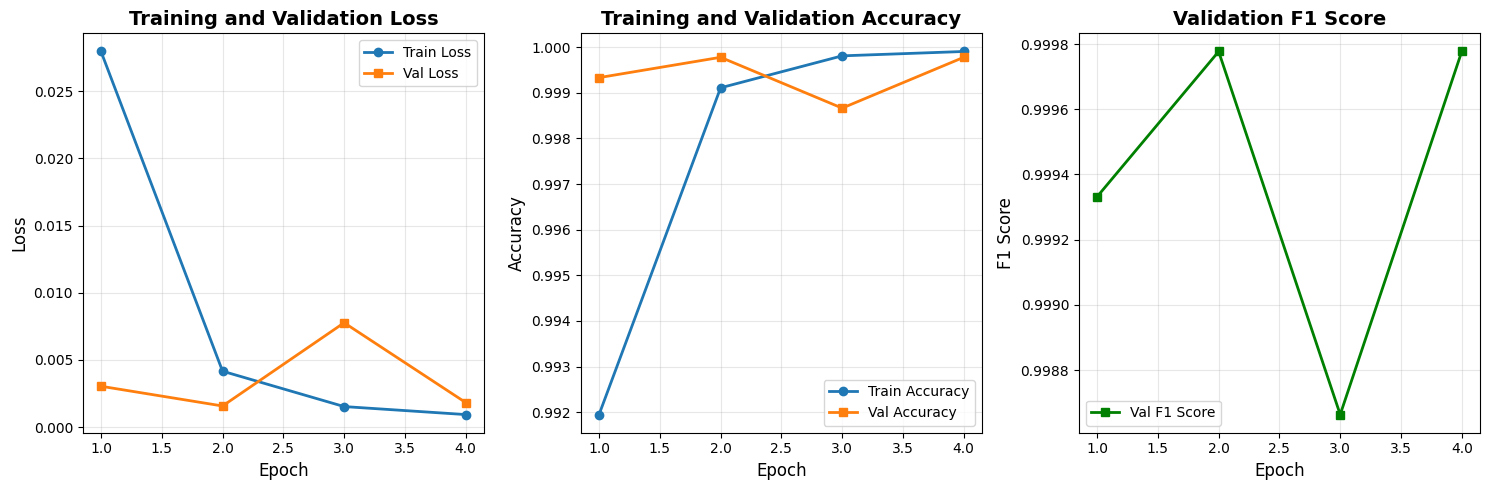

In [10]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(15, 5))

# Loss curve
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', linewidth=2)
plt.plot(epochs_range, history['val_loss'], label='Val Loss', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy curve
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
plt.plot(epochs_range, history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# F1 Score curve
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['val_f1'], label='Val F1 Score', marker='s', linewidth=2, color='green')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Validation F1 Score', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()



Loading Best Model for Testing


Evaluating: 100%|██████████| 562/562 [01:16<00:00,  7.32it/s]



FINAL TEST SET EVALUATION - BEST MODEL

Metric               Value     
------------------------------
Accuracy             0.9997
Precision            0.9997
Recall               0.9997
F1 Score             0.9997
Loss                 0.0027

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Fake News     1.0000    0.9994    0.9997      4695
   True News     0.9993    1.0000    0.9996      4283

    accuracy                         0.9997      8978
   macro avg     0.9997    0.9997    0.9997      8978
weighted avg     0.9997    0.9997    0.9997      8978


CONFUSION MATRIX
[[4692    3]
 [   0 4283]]

True Negative (Correctly identified Fake): 4692
False Positive (Fake labeled as True): 3
False Negative (True labeled as Fake): 0
True Positive (Correctly identified True): 4283


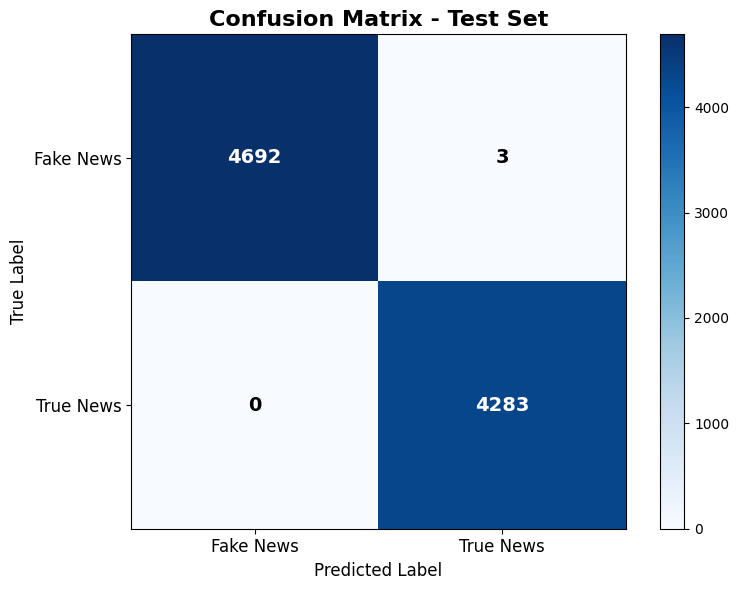


Evaluation Complete!

Best Model Metrics Summary:
  - Test Accuracy: 0.9997
  - Test Precision: 0.9997
  - Test Recall: 0.9997
  - Test F1 Score: 0.9997

Model saved as: best_fake_news_model.pt
Training curves saved as: training_curves.png
Confusion matrix saved as: confusion_matrix.png


In [11]:
print("\n" + "="*70)
print("Loading Best Model for Testing")
print("="*70)

# load best model
checkpoint = torch.load('best_fake_news_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# evaluate on testing data
test_acc, test_loss, test_f1, test_precision, test_recall, test_preds, test_labels_list = eval_model(
    model, test_loader, device
)

print("\n" + "="*70)
print("FINAL TEST SET EVALUATION - BEST MODEL")
print("="*70)

print(f"\n{'Metric':<20} {'Value':<10}")
print("-" * 30)
print(f"{'Accuracy':<20} {test_acc:.4f}")
print(f"{'Precision':<20} {test_precision:.4f}")
print(f"{'Recall':<20} {test_recall:.4f}")
print(f"{'F1 Score':<20} {test_f1:.4f}")
print(f"{'Loss':<20} {test_loss:.4f}")

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(
    test_labels_list,
    test_preds,
    target_names=['Fake News', 'True News'],
    digits=4
))

print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)
cm = confusion_matrix(test_labels_list, test_preds)
print(cm)
print(f"\nTrue Negative (Correctly identified Fake): {cm[0][0]}")
print(f"False Positive (Fake labeled as True): {cm[0][1]}")
print(f"False Negative (True labeled as Fake): {cm[1][0]}")
print(f"True Positive (Correctly identified True): {cm[1][1]}")

# visualize confussion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake News', 'True News'], fontsize=12)
plt.yticks(tick_marks, ['Fake News', 'True News'], fontsize=12)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14, fontweight='bold')

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("Evaluation Complete!")
print("="*70)
print(f"\nBest Model Metrics Summary:")
print(f"  - Test Accuracy: {test_acc:.4f}")
print(f"  - Test Precision: {test_precision:.4f}")
print(f"  - Test Recall: {test_recall:.4f}")
print(f"  - Test F1 Score: {test_f1:.4f}")
print(f"\nModel saved as: best_fake_news_model.pt")
print(f"Training curves saved as: training_curves.png")
print(f"Confusion matrix saved as: confusion_matrix.png")